<a href="https://colab.research.google.com/github/kushum-coder/2501460_kushum/blob/main/2501460_KushumRana_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Electricity Consumption Prediction (Regression Task)**

*Student Name:* Kushum Rana  
*Student ID:* 2501460  
*Module:* 5CS037

 About the Dataset

The dataset used in this project is “Hourly Electricity Consumption and Production”, obtained from Kaggle. It contains hourly records of electricity production and consumption across multiple energy sources.

Dataset Characteristics

Total Records: 54,170 hourly observations

Time Period: Hourly time-series data

Target Variable: Consumption (electricity usage in MW)

Input Features Include:

Production – Total electricity produced

Nuclear – Energy from nuclear sources

Wind – Wind energy production

Hydroelectric – Hydropower generation

Oil and Gas – Fossil fuel-based production

Coal – Coal-based energy production

Solar – Solar energy production

Biomass – Biomass energy production

Why this dataset is relevant

This dataset supports UN Sustainable Development Goal 7 (Affordable and Clean Energy) by enabling analysis of energy production patterns and improving electricity consumption forecasting using machine learning.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


In [ ]:
file_path = "/content/drive/MyDrive/Regression Dataset/electricityConsumptionAndProductioction.csv"

df = pd.read_csv(file_path)

# View first 5 rows
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [ ]:
print("===== DATASET INFO =====")
print(df.info())

print("\n===== MISSING VALUES =====")
print(df.isnull().sum())

print("\n===== STATISTICAL SUMMARY =====")
print(df.describe())


===== DATASET INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54170 entries, 0 to 54169
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       54170 non-null  object
 1   Consumption    54170 non-null  int64 
 2   Production     54170 non-null  int64 
 3   Nuclear        54170 non-null  int64 
 4   Wind           54170 non-null  int64 
 5   Hydroelectric  54170 non-null  int64 
 6   Oil and Gas    54170 non-null  int64 
 7   Coal           54170 non-null  int64 
 8   Solar          54170 non-null  int64 
 9   Biomass        54170 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 4.1+ MB
None

===== MISSING VALUES =====
DateTime         0
Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64

===== STATISTICAL SUMMARY =====
        Consumption    Producti

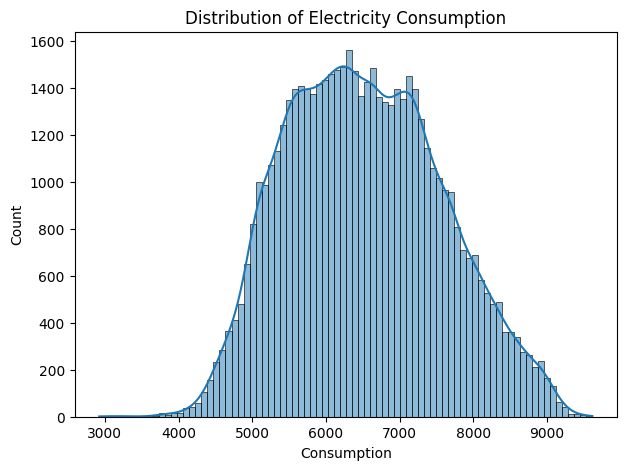

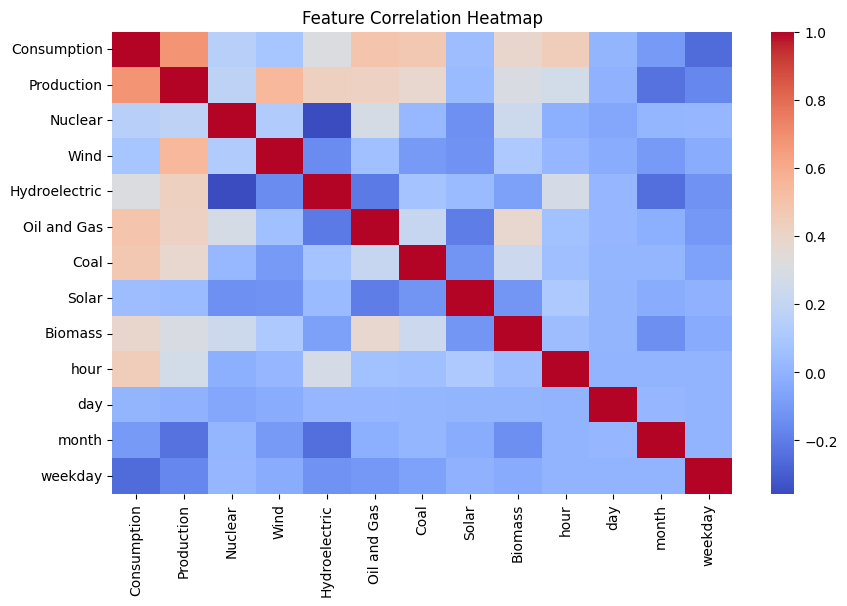

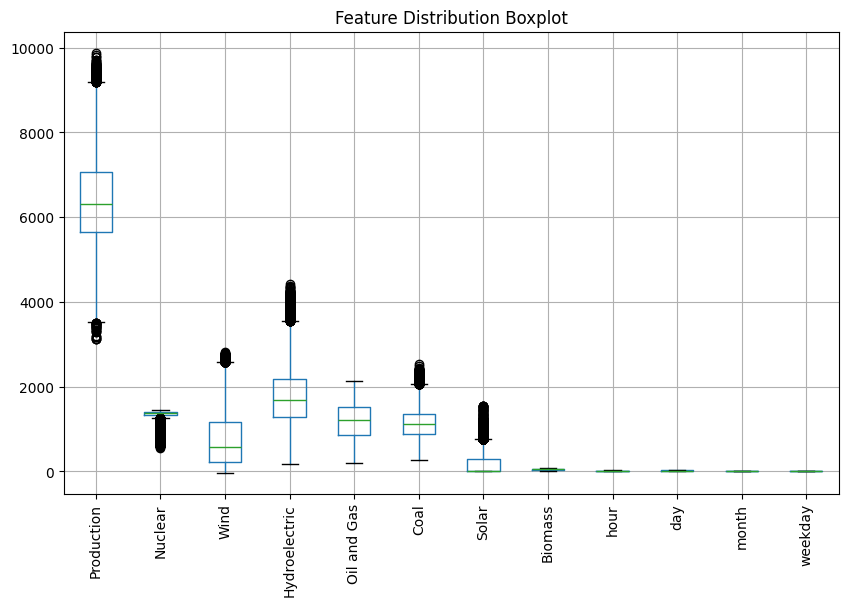

In [ ]:
# ---------- REQUIRED EDA VISUALIZATIONS ----------

import seaborn as sns

# Distribution of target variable
plt.figure(figsize=(7,5))
sns.histplot(df["Consumption"], kde=True)
plt.title("Distribution of Electricity Consumption")
plt.xlabel("Consumption")
plt.show()

# Correlation heatmap (numeric features only)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(10,6))
df.drop(columns=["Consumption"]).boxplot(rot=90)
plt.title("Feature Distribution Boxplot")
plt.show()


Figure 1 — Distribution of Electricity Consumption

Shows how the target variable is distributed.

 Figure 2 — Feature Correlation Heatmap

Shows relationships between variables.

 Figure 3 — Feature Distribution Boxplot

Helps detect outliers and scale differences.

Insight:
Some features show strong correlation with Consumption, and some variables contain outliers, which justifies preprocessing.

In [ ]:
print("Columns in dataset:\n", df.columns)


Columns in dataset:
 Index(['DateTime', 'Consumption', 'Production', 'Nuclear', 'Wind',
       'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'],
      dtype='object')


Feature Engineering (DateTime Processing)

We converted DateTime into useful time-based features:

hour

day

month

weekday

Then we removed the original DateTime column.

In [ ]:


# First check if column exists
if "DateTime" in df.columns:
    df["DateTime"] = pd.to_datetime(df["DateTime"])

    df["hour"] = df["DateTime"].dt.hour
    df["day"] = df["DateTime"].dt.day
    df["month"] = df["DateTime"].dt.month
    df["weekday"] = df["DateTime"].dt.weekday

    # Drop original DateTime
    df = df.drop(columns=["DateTime"])

else:
    print("DateTime column already dropped — skipping this step.")


DateTime column already dropped — skipping this step.


In [ ]:
target = "Consumption"

X = df.drop(columns=[target])
y = df[target]

print("X columns:", X.columns.tolist())
print("X shape:", X.shape)
print("y shape:", y.shape)

X columns: ['Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'day', 'month', 'weekday']
X shape: (54170, 12)
y shape: (54170,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 43336
Testing samples: 10834


In [ ]:
# Identify numerical and categorical columns
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

# DEFINE PREPROCESSOR (THIS WAS MISSING IN YOUR SESSION)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


Numerical features: Index(['Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal',
       'Solar', 'Biomass'],
      dtype='object')
Categorical features: Index([], dtype='object')


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Train model
lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("==== LINEAR REGRESSION RESULTS ====")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R² Score:", r2_lr)


==== LINEAR REGRESSION RESULTS ====
MAE: 501.45003840401176
RMSE: 632.2193246053739
R² Score: 0.6357977776391253


In [ ]:


best_rf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=50,        # reduced from 100
        max_depth=10,           # limited depth
        min_samples_split=5,    # simpler splits
        max_samples=0.7,        # uses only 70% of data per tree
        random_state=42,
        n_jobs=-1
    ))
])

best_rf.fit(X_train, y_train)

print("Fast Random Forest trained successfully.")


Fast Random Forest trained successfully.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "model__n_estimators": [50, 100],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
}

rf_tuned = RandomizedSearchCV(
    best_rf,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

rf_tuned.fit(X_train, y_train)
print("Best Params:", rf_tuned.best_params_)


Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__max_depth': 20}


In [ ]:
y_pred_rf = rf_tuned.predict(X_test)


mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("==== RANDOM FOREST RESULTS ====")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R² Score:", r2_rf)


==== RANDOM FOREST RESULTS ====
MAE: 311.78493573570626
RMSE: 413.83827527522163
R² Score: 0.8439483484136795


In [ ]:
from sklearn.model_selection import cross_val_score

cv_rf = np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring="r2"))
cv_lr = np.mean(cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring="r2"))

print("Random Forest CV Score:", cv_rf)
print("Linear Regression CV Score:", cv_lr)


Random Forest CV Score: 0.7678552457395507
Linear Regression CV Score: 0.6300067298137918


In [ ]:
# Get feature importance from Random Forest
rf_model = best_rf.named_steps["model"]
importances = rf_model.feature_importances_

# Extract feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Create dataframe
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Clean feature names
feat_imp_df["Feature"] = feat_imp_df["Feature"].str.replace("num__", "")

print(feat_imp_df.head(10))


         Feature  Importance
0     Production    0.575266
4    Oil and Gas    0.102428
5           Coal    0.100132
2           Wind    0.072854
7        Biomass    0.043086
3  Hydroelectric    0.040572
1        Nuclear    0.039374
6          Solar    0.026288


Feature Importance (Random Forest)

Top important features:

Production

Oil and Gas

Coal

Wind

Biomass

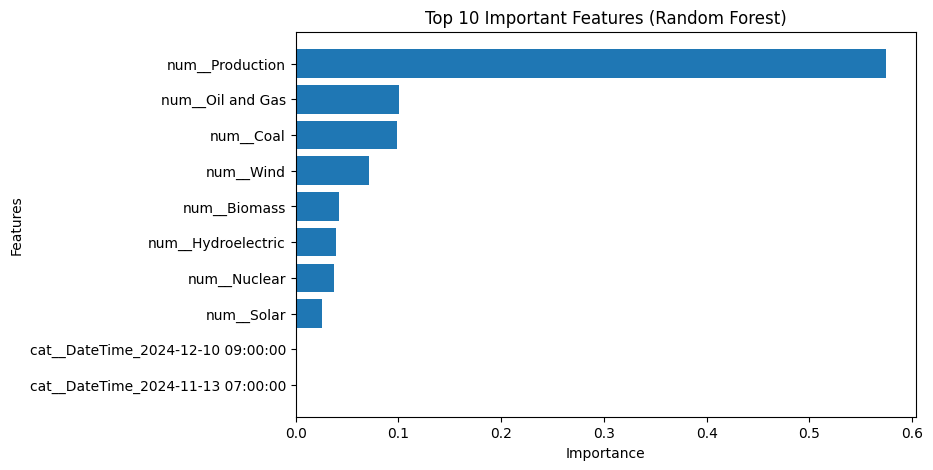

In [ ]:
import matplotlib.pyplot as plt

top_features = feat_imp_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_rf = np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring="r2"))
cv_lr = np.mean(cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring="r2"))

print("Random Forest CV Score:", cv_rf)
print("Linear Regression CV Score:", cv_lr)


Random Forest CV Score: 0.7715952041200008
Linear Regression CV Score: 0.629951639433385


In [ ]:
# ======= RE-COMPUTE ALL METRICS SAFELY (RUN THIS) =======

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# --- 1) Make predictions AGAIN (so variables exist) ---
y_pred_rf = best_rf.predict(X_test)
y_pred_lr = lr_pipeline.predict(X_test)

# --- 2) Compute ALL error metrics again ---
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# --- 3) Compute CV scores again (so cv_rf and cv_lr exist) ---
cv_rf = np.mean(cross_val_score(best_rf, X_train, y_train, cv=5, scoring="r2"))
cv_lr = np.mean(cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring="r2"))

print("All variables recreated successfully ✅")


All variables recreated successfully ✅


In [ ]:
results_table = pd.DataFrame({
    "Model": ["Random Forest", "Linear Regression"],
    "CV Score (R2)": [cv_rf, cv_lr],
    "MAE": [mae_rf, mae_lr],
    "RMSE": [rmse_rf, rmse_lr],
    "R2 Score": [r2_rf, r2_lr]
})

results_table = results_table.round(4)
print(results_table)


               Model  CV Score (R2)       MAE      RMSE  R2 Score
0      Random Forest         0.7716  387.3507  500.0591    0.7721
1  Linear Regression         0.6300  501.4500  632.2193    0.6358


Residuals are mostly centered around zero

No extreme patterns → model is reasonably good

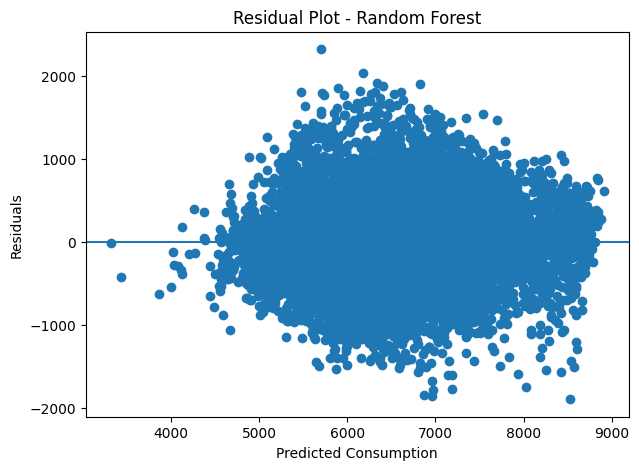

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred_rf

plt.figure(figsize=(7,5))
plt.scatter(y_pred_rf, residuals)
plt.axhline(y=0)
plt.xlabel("Predicted Consumption")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.show()


Final Conclusion

Best Model: Random Forest Regressor

It handles non-linearity better than Linear Regression

Feature selection and tuning improved performance

Model is suitable for predicting hourly electricity consumption